# Исследование поведения пользователей

## Описание проекта
Работая в стартапе по продаже продуктов питания, необходимо посмотреть, как ведут себя пользователи нашего мобильного приложения, проследить их путь до покупки товара, провести ААВ тест 

## Описание данных

`event` — название события;\
`userid` — уникальный идентификатор пользователя;\
`dwt` — (date with time) время события;\
`group` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная;\
`date` - дата события

## Цели проекта

- Подготовить данные к анализу
- Проверить данные в датасете
- Изученить воронку продаж
- Изучить результат, проведенного A/A/B-эксперимента (Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми)

### Подготовка данных

Для начала импортируем необходимые нам библиотеки

In [1]:
import pandas as pd

In [2]:
import scipy.stats as stats

In [3]:
import matplotlib.pyplot as plt

In [4]:
import numpy as np

In [5]:
import datetime as dt

In [6]:
import plotly.express as px

In [7]:
from plotly import graph_objects as go

In [8]:
from scipy import stats as st

In [9]:
import math as mth

In [10]:
import seaborn as sns

Откроем файл и выведем первые 5 строк для ознакомления

In [11]:
data = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')

In [12]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Итак, из выведенного фрагмента, можно видеть проблему с названиями столбцов, во-первых, их регистр не соответствует правилам хорошего тона, во-вторых, в таких названиях легко запутаться и допустить ошибку. Приведем название столбцов к нижнему регистру и переименуем столбцы

In [13]:
data.columns = data.columns.str.lower()

In [14]:
data = data.rename(columns = {'eventname':'event', 'deviceidhash':'userid', 'eventtimestamp':'dwt', 'expid':'group'})

Новая проблема, вместо даты что-то странное, причина этому, "эпоха Unix". Это система описания моментов, которая расчитывается в секундах от 1 января 1970 года. Воспользуемся функцией `pd.to_datetime`, применив параметр `unit = 's'` для предотвращения этой проблемы

In [15]:
data['dwt'] = pd.to_datetime(data['dwt'],unit = 's')

Посмотрим на результат

In [16]:
data.head()

,event,userid,dwt,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


Добавим новый столбец `date` с датой события и приведем его к типу `datetime 64`

In [17]:
data['date'] = data['dwt'].dt.date.astype('datetime64[D]')

In [18]:
data.head()

,event,userid,dwt,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


Выведем информацию о датасете на экран

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   event   244126 non-null  object        
 1   userid  244126 non-null  int64         
 2   dwt     244126 non-null  datetime64[ns]
 3   group   244126 non-null  int64         
 4   date    244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


Проверим есть ли дубликаты, если есть удалим их и проверим информацию о датасете

In [20]:
data.duplicated().sum()

413

In [21]:
data = data.drop_duplicates()

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   event   243713 non-null  object        
 1   userid  243713 non-null  int64         
 2   dwt     243713 non-null  datetime64[ns]
 3   group   243713 non-null  int64         
 4   date    243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.2+ MB


Из информации о датасете видно, что пропусков у нас нет, поэтому можем смело переходить дальше

### Изучение и проверка данных

Посмотрим сколько всего событий в логе и как они распределяются

In [23]:
data.event.count()

243713

In [24]:
data.event.value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event, dtype: int64

Посмотрим на количество уникальных пользователей в логе

In [25]:
data.userid.nunique()

7551

Посмотрим на среднее количество событий на пользователя

In [26]:
event_total = data['event'].count()
unique_user = data.userid.nunique()
avg_event = event_total / unique_user
round(avg_event)

32

У нас получилось 32 события на 1 пользователя, видимо некоторые пользователи очень любят заходить на главную страницу и просматривать предложения. Далее посмотрим за какой период мы располагаем данными

In [27]:
data.date.agg({'min','max'})

max   2019-08-07
min   2019-07-25
Name: date, dtype: datetime64[ns]

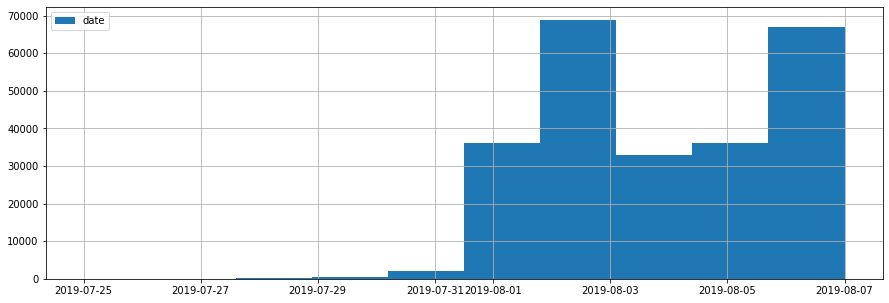

In [28]:
data.date.hist(figsize = (15,5), legend = True);

У нас есть данные с 25 июля 2019 года по 7 августа 2019 года, но из графика видно, что у нас не одинаково полные данные за весь период, поэтому было решено взять данные с 1 августа 2019 года, где данные становятся наиболее полными, отсортируем наш датафрейм с учетом корректировки

In [29]:
data_new = data.query('date >= "2019-08-01"')

In [30]:
data_new.head()

,event,userid,dwt,group,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


Посмотрим сколько событий и пользователей мы потеряли при фильтрации данных

In [31]:
event_new = data_new.event.count()

In [32]:
event_total - event_new

2826

In [33]:
100 - round(event_new/event_total)

99

In [34]:
unique_user_new = data_new.userid.nunique()

In [35]:
unique_user - unique_user_new

17

In [36]:
100 - round(unique_user_new/unique_user)

99

Мы потеряли около 3 тысяч событий и 17 пользователей, то есть не более 1 % данных. Посмотрим располагаем ли мы данными из всех трёх групп

In [37]:
data_new.groupby('group')['userid'].agg('nunique')

group
246    2484
247    2513
248    2537
Name: userid, dtype: int64

Данные есть из всех трёх групп, количество участников отличается, рассмотрим этот момент в дальнейшем исследовании

### Изучение воронки событий

Плсмотрим какие события у нас есть в логах

In [38]:
data_new.event.unique()

array(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear',
       'CartScreenAppear', 'PaymentScreenSuccessful'], dtype=object)

У нас есть следующие события:
- `Tutorial`(руководство пользователя);
- `MainScreenAppear` (просмотр главного экрана);
- `OffersScreenAppear` (просмотр предложения);
- `CartScreenAppear` (введение данных карты);
- `PaymentScreenSuccessful` (окно успешной оплаты)

In [39]:
data_new.event.value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event, dtype: int64

Итак, больше всего пользователей совершают просмотр главного экрана, следующим по частоте просмотр страницы с предложением, далее введение данных о банковской карте и наконец страница успешной оплаты. Событие `tutorial` это обучение пользователя работы с сайтом практически не востребовано, поэтому будет логичным исключить данное событие из воронки событий. Проверим сколько событий приходится на одного уникального пользователя, для этого создадим переменную `event_users`, в которой будет распределение уникальных пользователей по событиям и их количество, и создадим индексацию 

In [40]:
event_users = data_new.groupby('event')['userid'].agg(['count','nunique']).reset_index()
event_users.columns =['event_name', 'n_events', 'n_users']

In [41]:
event_users

,event_name,n_events,n_users
0,CartScreenAppear,42303,3734
1,MainScreenAppear,117328,7419
2,OffersScreenAppear,46333,4593
3,PaymentScreenSuccessful,33918,3539
4,Tutorial,1005,840


Посмотрим сколько пользователей совершили хотя бы одно событие, возьмем ситуацию, когда у нас пользователи сначала переходят на главный экран, а потом уже совершают все остальные действия

In [42]:
event_users['n_users'][0]

3734

In [43]:
unique_user_new

7534

In [44]:
100 - round(unique_user_new / event_users['n_users'][0])

98

То есть 99 % пользователей совершают действия сразу начиная с посещения главного экрана, скорее всего 1 % пользователей начинают со знакомства с руководством пользователя и понимают что это слишком сложно и перестают взаимодействовать с платформой, поэтому принято решение удалить их из воронки продаж, что мы и сделали в переменной `event_users_w`

In [45]:
event_users_w = event_users[event_users['event_name'] != 'Tutorial']\
.sort_values(by = ['n_events', 'n_users'], ascending = False)

In [46]:
event_users_w

,event_name,n_events,n_users
1,MainScreenAppear,117328,7419
2,OffersScreenAppear,46333,4593
0,CartScreenAppear,42303,3734
3,PaymentScreenSuccessful,33918,3539


По действиям, предположительно, пользователи посещают главную страницу - просматривают предложения - далее принимают решения о покупке (вводят данные карты) - оплачивают товар, но существует и другой путь, пропуская посещение главного экрана и, начиная сразу с просмотра страниц с предложениями

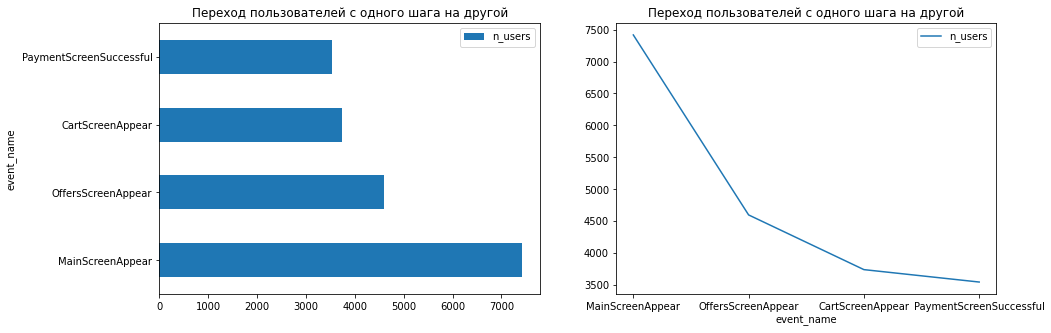

In [47]:
fig, axes = plt.subplots(1, 2)
event_users_w.plot(kind = 'line', x = 'event_name', y = 'n_users',\
                   title = 'Переход пользователей с одного шага на другой', ax = axes[1]);
event_users_w.plot(kind = 'barh', x = 'event_name', y = 'n_users', figsize = (15,5),\
                   title = 'Переход пользователей с одного шага на другой', ax = axes[0]);

Наши предположения по действиям пользователей можно проследить на графиках, наибольшее количество пользователей на событии - посещение главной страницы, а наименьшее - на успешном оформлении заказа.

Посмотрим какой процент пользователей "отваливается" при переходе с шага на шаг. Для этого скопируем датафрейм `event_user_w` в переменную `users` и посчитаем первоначаьный процент пользователей на каждом шагу, процент потери при переходе с шага на шаг, процент оставшихся пользователей, их положим в переменные `per`, `new_step` и `alive` соответственно

In [48]:
users = event_users_w.copy()

In [49]:
users['per'] = round(users['n_users'].div(unique_user_new) *100,2)
users['new_step'] = round(users['n_users'] / users['n_users'].shift() *100, 2)
users['alive'] = 100 - users['new_step']

In [50]:
users

,event_name,n_events,n_users,per,new_step,alive
1,MainScreenAppear,117328,7419,98.47,NaN,NaN
2,OffersScreenAppear,46333,4593,60.96,61.91,38.09
0,CartScreenAppear,42303,3734,49.56,81.30,18.70
3,PaymentScreenSuccessful,33918,3539,46.97,94.78,5.22


Больше всего пользователей мы теряем на 2 шаге (почти 62 %) на переходе со страницы основного экрана на страницу предложения, из причин могу предположить, не цепляющий интерфейс или не интересная информация на главном экране, которая не подталкивает пользователя сделать выбор в пользу того или иного товара

Посмотрим какая доля пользователей доходит от первого события до оплаты, для этого мы пользователей с оплаты поделим на пользователей с первого события и умножим на 100

In [51]:
round(event_users_w['n_users'][3] / event_users_w['n_users'][0] * 100, 2)

94.78

47.7 % пользователей доходит от первого шага до оплаты, посмотрим на результаты эксперимента, может там мы найдем разгадку как увеличить эту цифру

### Изучение результатов эксперимента

Посмотрим сколько пользователей в каждой экспериментальной группе

In [52]:
data_new = data_new.query('event != "Tutorial"')

In [53]:
users_total = data_new.groupby('group')['userid'].agg('nunique')

In [54]:
users_total

group
246    2483
247    2512
248    2535
Name: userid, dtype: int64

Проверим пользователей, которые могли участвовать в двух или нескольких группах одновременно

In [55]:
data_new.groupby('userid').agg({'group':'nunique'}).query('group > 1').count()

group    0
dtype: int64

Похоже, что у нас честный эксперимент и пользователи участвуют только в одной группе

Выведем только те столбцы, с которыми мы будем работать и создадим сводную таблицу по этим данным, также добавим столбец `total`, в котором посчитаем сколько всего gjkmpjdfntktq в каждой из групп

In [56]:
data_new_3 = data_new[['event','userid','group']]

In [57]:
data_new_3['total'] = data_new_3.groupby('group')['userid'].transform('nunique')

/tmp/ipykernel_49/2669507418.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new_3['total'] = data_new_3.groupby('group')['userid'].transform('nunique')


In [58]:
data_new_3.head()

,event,userid,group,total
2829,MainScreenAppear,3737462046622621720,246,2483
2830,MainScreenAppear,3737462046622621720,246,2483
2831,OffersScreenAppear,3737462046622621720,246,2483
2832,MainScreenAppear,1433840883824088890,247,2512
2833,MainScreenAppear,4899590676214355127,247,2512


Создадим датафрейм с числом пользователей по каждому событию в разбиении на группы

In [59]:
event_groups = data_new_3.pivot_table(index='event', columns='group',values='userid',aggfunc='nunique')\
                       .sort_values(246,ascending=False)
event_groups['246+247'] = event_groups[246] + event_groups[247]

event_groups

group,246,247,248,246+247
event,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358


Также для эксперимента, нам понадобится таблица с суммарным количеством пользователей по группам

In [68]:
users = data_new_3.groupby('group')['userid'].nunique().reset_index()
users.loc[3] = ['246+247', 4997]
users = users.set_index(users.columns[0])
users

,userid
group,
246,2483
247,2512
248,2535
246+247,4997


Посмотрим распределение пользователей по группам на основании круговой диаграмме, где отдельным сектором выделена экспериментальная группа

In [60]:
group = data_new_3.groupby('group')['userid'].agg('nunique')

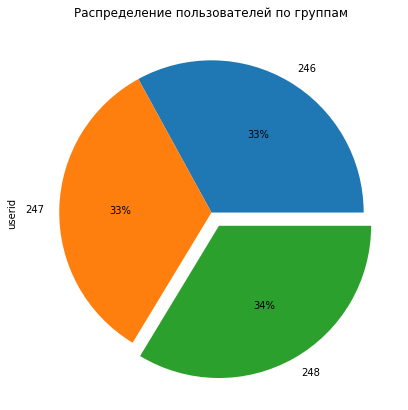

In [61]:
my_explode=(0.0,0.0,0.1)
group.plot(kind = 'pie', autopct='%1.0f%%', figsize=(7,7), explode=my_explode,\
          title = 'Распределение пользователей по группам');

Можно приступать к написанию функции для Z теста

In [63]:
alpha = .05 # критический уровень статистической значимости
def z_test(exp1, exp2, event, alpha): 
    p1_event = event_groups.loc[event, exp1] 
    p2_event = event_groups.loc[event, exp2] 
    p1_users = users.loc[exp1, 'userid'] 
    p2_users = users.loc[exp2, 'userid'] 
    p1 = p1_event / p1_users # пропорция успехов в первой группе
    p2 = p2_event / p2_users # пропорция успехов во второй группе
    difference = p1 - p2 # разница пропорций
    p_combined = (p1_event + p2_event) / (p1_users + p2_users) # пропорция успехов в комбинированном датасете
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / p1_users + 1 / p2_users))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('Проверка для  {} и {}, событие: {}, p-значение: {p_value:.2f}'.format(exp1, exp2, event, p_value=p_value))
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу о равенстве конверсии в группах")
    else:
        print("Не получилось отвергнуть нулевую гипотезу о равенстве конверсии в группах")

Проверим, находят ли статистические критерии разницу между выборками 246 и 247, для этого выполним `Проверку гипотезы о равенстве долей`, используя таблицу `event_groups`

In [64]:
# Группы 246 и 247
for event in event_groups.index:
    z_test(246, 247, event, alpha)
    print()

Проверка для  246 и 247, событие: MainScreenAppear, p-значение: 0.75
Не получилось отвергнуть нулевую гипотезу о равенстве конверсии в группах

Проверка для  246 и 247, событие: OffersScreenAppear, p-значение: 0.25
Не получилось отвергнуть нулевую гипотезу о равенстве конверсии в группах

Проверка для  246 и 247, событие: CartScreenAppear, p-значение: 0.23
Не получилось отвергнуть нулевую гипотезу о равенстве конверсии в группах

Проверка для  246 и 247, событие: PaymentScreenSuccessful, p-значение: 0.11
Не получилось отвергнуть нулевую гипотезу о равенстве конверсии в группах



То же самое проделаем и с данными из других групп

In [65]:
# Группы 246 и 248
for event in event_groups.index:
    z_test(246, 248, event, alpha)
    print()

Проверка для  246 и 248, событие: MainScreenAppear, p-значение: 0.34
Не получилось отвергнуть нулевую гипотезу о равенстве конверсии в группах

Проверка для  246 и 248, событие: OffersScreenAppear, p-значение: 0.21
Не получилось отвергнуть нулевую гипотезу о равенстве конверсии в группах

Проверка для  246 и 248, событие: CartScreenAppear, p-значение: 0.08
Не получилось отвергнуть нулевую гипотезу о равенстве конверсии в группах

Проверка для  246 и 248, событие: PaymentScreenSuccessful, p-значение: 0.22
Не получилось отвергнуть нулевую гипотезу о равенстве конверсии в группах



In [66]:
# Группы 247 и 248
for event in event_groups.index:
    z_test(247, 248, event, alpha)
    print()

Проверка для  247 и 248, событие: MainScreenAppear, p-значение: 0.52
Не получилось отвергнуть нулевую гипотезу о равенстве конверсии в группах

Проверка для  247 и 248, событие: OffersScreenAppear, p-значение: 0.93
Не получилось отвергнуть нулевую гипотезу о равенстве конверсии в группах

Проверка для  247 и 248, событие: CartScreenAppear, p-значение: 0.59
Не получилось отвергнуть нулевую гипотезу о равенстве конверсии в группах

Проверка для  247 и 248, событие: PaymentScreenSuccessful, p-значение: 0.73
Не получилось отвергнуть нулевую гипотезу о равенстве конверсии в группах



In [67]:
# Группы 246+247 и 248
for event in event_groups.index:
    z_test('246+247', 248, event, alpha)
    print()

Проверка для  246+247 и 248, событие: MainScreenAppear, p-значение: 0.43
Не получилось отвергнуть нулевую гипотезу о равенстве конверсии в группах

Проверка для  246+247 и 248, событие: OffersScreenAppear, p-значение: 0.46
Не получилось отвергнуть нулевую гипотезу о равенстве конверсии в группах

Проверка для  246+247 и 248, событие: CartScreenAppear, p-значение: 0.19
Не получилось отвергнуть нулевую гипотезу о равенстве конверсии в группах

Проверка для  246+247 и 248, событие: PaymentScreenSuccessful, p-значение: 0.62
Не получилось отвергнуть нулевую гипотезу о равенстве конверсии в группах



На основании проведенных тестов, с уверенностью можно сказать, что поведение пользователей групп не зависят от изменении шрифта приложения, поэтому менять или не менять шрифт решать уже руководству компании, в любом случае прибыль останется на прежднем уровне